In [1]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from urllib import request
import json
import os
from tqdm.notebook import tqdm

import statsmodels.api as sm
from statsmodels.formula.api import ols
from tqdm.notebook import tqdm
from statsmodels.stats.multitest import multipletests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

In [2]:
de_dir_path = '../../data/DE/ANOVA_mean/'

In [3]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']

In [4]:
os.listdir(de_dir_path)

['anova_mamm_mean.csv',
 'cluster_spectr_anova_mean_6.csv',
 'cluster_spectr_anova_mean_7.csv',
 'cluster_spectr_anova_mean_8.csv',
 'cluster_spectr_anova_mean_9.csv',
 'ttest_mamm_mean.csv']

## Load files

### DE results

In [5]:
anova_res = pd.read_csv(de_dir_path + 'anova_mamm_mean.csv', index_col=0)
anova_genes = anova_res[anova_res.p_val_adj < 0.05].index
anova_res.head()

,sum_sq,df,F,PR(>F),p_val_adj
A1BG,0.122578,12.0,2.796490,0.003701,0.010364
AAAS,0.017527,12.0,0.944161,0.509517,0.596369
AACS,0.136394,12.0,2.729393,0.004508,0.012212
AADAT,0.057031,12.0,5.478881,0.000002,0.000016
AAGAB,0.043359,12.0,2.127609,0.026045,0.053640


In [6]:
n_clusters = 7
anova_labels = pd.read_csv(de_dir_path + f'cluster_spectr_anova_mean_{n_clusters}.csv', index_col=0)['0'].sort_values()
anova_labels = anova_labels
anova_labels.name = 'ANOVA_labels'

## Load normalized pseudobulks

In [7]:
pb_dir_path = './results/'

In [8]:
os.listdir(pb_dir_path)

['.ipynb_checkpoints',
 'ancova_3df_res.pkl',
 'ancova_perm_res.pkl',
 'ancova_res.pkl',
 'chimp_clusters_28.csv',
 'chimp_clusters_50.csv',
 'chimp_clusters_77.csv',
 'gene_selection_df.csv',
 'hs_anova_inter_clusters.csv',
 'hs_layers.csv',
 'hs_prof.csv',
 'hs_prof_anova.csv',
 'hs_ttest_inter_clusters.csv',
 'human_clusters_28.csv',
 'human_clusters_50.csv',
 'human_clusters_67.csv',
 'human_clusters_77.csv',
 'human_clusters_ancova.csv',
 'hum_spec_onehot.csv',
 'l1_distances.pkl',
 'macaque_clusters_28.csv',
 'macaque_clusters_77.csv',
 'mean_norm_clust_allgenes.csv',
 'optimal_model_res.pkl',
 'pb_mammals_samplenorm_mean_filtered.h5ad',
 'specie_specific_genes_tr28.pkl',
 'specie_specific_genes_tr35.pkl',
 'specie_specific_genes_tr50.pkl',
 'specie_specific_genes_tr67.pkl',
 'specie_specific_genes_tr77.pkl',
 'zscore_norm_clust_allgenes.csv']

In [9]:
adata_pb_norm = sc.read_h5ad(pb_dir_path + 'pb_mammals_samplenorm_mean_filtered.h5ad')
#adata_pb_norm_mean.var = anova_res
adata_pb_norm

AnnData object with n_obs × n_vars = 89 × 5390
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition', 'lib_size', 'log_lib_size'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props'

In [10]:
background_genes = adata_pb_norm.var_names.tolist()
len(background_genes)

5390

### Create dataframe

In [11]:
df = pd.DataFrame(adata_pb_norm.X, index=adata_pb_norm.obs_names, columns=adata_pb_norm.var_names)

In [12]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque']:
    samples = df.loc[df.index.str.contains(cond)].index
    order = sorted(samples.tolist(), key=lambda x: x[-2:])
    order_laminar = list(filter(lambda x: 'L' in x, order))
    order_wm = list(filter(lambda x: 'WM' in x, order))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque']
df = df.loc[sample_order['all']]

In [13]:
df.head()

,AACS,AAGAB,AAK1,AAMP,AAR2,AARS1,AARS2,AASDH,AASDHPPT,AATF,...,ZNFX1,ZNHIT3,ZNRD2,ZNRF1,ZPR1,ZRANB2,ZSCAN18,ZSCAN21,ZUP1,ZZZ3
human_759_WM,0.041268,0.025707,-0.072019,0.051644,-0.040637,0.007453,-0.047439,0.013681,-0.112373,-0.027305,...,0.002537,-0.145321,-0.012920,-0.019393,0.010821,0.002873,0.018861,0.032487,-0.083505,-0.040384
human_j12_WM,0.025153,-0.044543,0.001885,0.044115,-0.005605,0.064853,-0.020012,0.036537,-0.247531,0.059761,...,0.029141,-0.053724,0.029411,-0.080373,-0.068238,-0.011533,-0.072855,-0.043932,-0.005179,0.055280
human_j3_WM,-0.028083,-0.011412,0.121080,-0.036493,-0.043526,-0.017252,-0.003079,0.047993,-0.150683,0.065300,...,0.026583,-0.017077,0.022215,-0.106516,0.025459,0.008847,-0.013096,-0.029365,0.055279,0.020677
human_j4_WM,-0.020194,-0.054054,0.040012,-0.023853,0.081220,0.055494,-0.012639,-0.001961,-0.177060,0.061381,...,0.055548,-0.082023,0.017378,-0.073447,0.030231,-0.000191,-0.116543,-0.023978,0.012403,0.078987
human_j6_WM,0.004524,0.010688,0.078731,0.049893,-0.014778,-0.074468,-0.035236,-0.024390,0.091938,0.022454,...,-0.049726,-0.146974,0.022209,0.003881,0.070576,0.027428,-0.033470,-0.019749,0.130150,0.027191


### Fit the spline

In [14]:
df_cont = df.copy()
df_cont['condition'] = adata_pb_norm.obs.condition
df_cont['layer'] = adata_pb_norm.obs.layer
df_cont['layer'] = df_cont.layer.map(dict(zip(sorted(df_cont.layer.unique()), range(1, 8)))).astype(int)
#df_cont['intercept'] = 1

In [15]:
#df_cont.columns = df_cont.columns.str.replace('-', '')

In [16]:
import numpy as np
np.random.seed(1234)
n = 200
def func(x):
   return x**3 + x**2 * np.sin(4 * x)
x = np.sort(np.random.random_sample(n) * 4 - 2)
y = func(x) + np.random.normal(scale=1.5, size=n)

In [17]:
from scipy.interpolate import make_smoothing_spline, BSpline
spl = make_smoothing_spline(x, y)

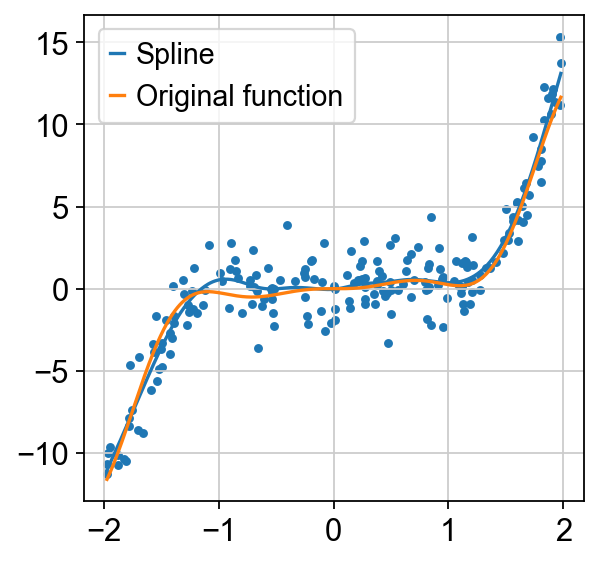

In [18]:
grid = np.linspace(x[0], x[-1], 400)
plt.plot(grid, spl(grid), label='Spline')
plt.plot(grid, func(grid), label='Original function')
plt.scatter(x, y, marker='.')
plt.legend(loc='best')
plt.show()

In [19]:
from scipy.interpolate import UnivariateSpline
gene = 'AAR2'
subs_index = df_cont[df_cont.condition == 'human'].index
targ_dataset = df_cont.loc[subs_index].copy().sort_values(by='layer')
x = targ_dataset['layer'].values
y = targ_dataset[gene].values
spl = UnivariateSpline(x, y, k=3)

#model = ols(formula, data=df_cont, subset=subs_index).fit()
#model_list.append([formula_index, model.f_pvalue])

In [20]:
layer_mean = (
    targ_dataset
    .drop('condition', axis=1)
    .groupby('layer')
    .mean()[gene]
)

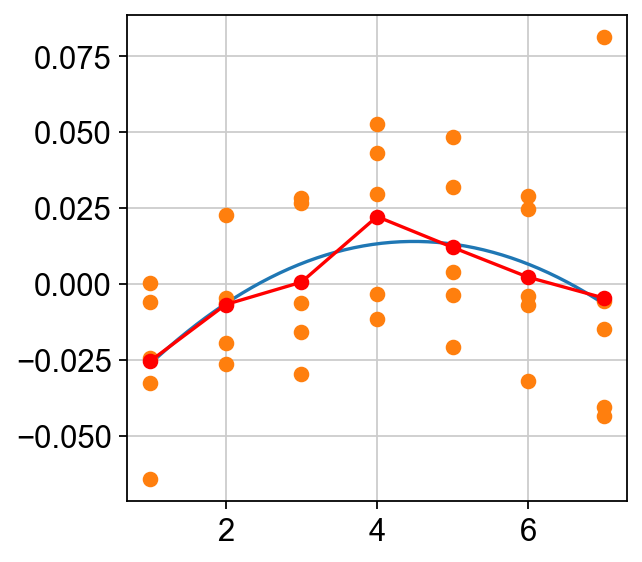

In [21]:
grid = np.linspace(1, 7)
plt.plot(grid, spl(grid), label='Spline')
plt.plot(x, y, 'o')
plt.plot(np.arange(1, 8), layer_mean, 'r-o')
#plt.scatter(x, y, marker='.')
#plt.legend(loc='best')
plt.show()

In [22]:
def fit_spline(df_targ, index, gene, order=3):
    """
    Function to fit a spline and return its residuals
    """
    targ_dataset = df_targ.loc[index].copy().sort_values(by='layer')
    x = targ_dataset['layer'].values
    y = targ_dataset[gene].values
    spline_model = UnivariateSpline(x, y, k=order)
    residuals = spline_model.get_residual()
    return residuals

In [23]:
gene = 'AAR2'
ref_specie, sec_specie = 'human', 'chimp'

# fit spline for reference specie
ref_index = df_cont[df_cont.condition == ref_specie].index
res_ref = fit_spline(df_cont, ref_index, gene)

# fit spline for second specie
sec_index = df_cont[df_cont.condition == sec_specie].index
res_sec = fit_spline(df_cont, sec_index, gene)

# fit spline for both species
both_index = df_cont[df_cont.condition.isin([ref_specie, sec_specie])].index
res_both = fit_spline(df_cont, both_index, gene)

# calculate f_stat
f_stat = (res_both - res_ref - res_sec) / (res_ref + res_sec)

In [24]:
def get_perm_distr(df_targ, gene, both_index, ref_size, res_both, n_iters=10000):
    fake_f_stat = np.zeros(n_iters)
    for i in np.arange(n_iters):
        # permute
        permutation = np.random.permutation(both_index)
        # calculate residuals ref
        ref_perm = permutation[:ref_size]
        res_ref_perm = fit_spline(df_targ, ref_perm, gene)
        # calculate residuals second
        sec_perm = permutation[ref_size:]
        res_sec_perm = fit_spline(df_targ, sec_perm, gene)
        # calculate f-stat
        fake_f_stat[i] = (res_both - res_ref_perm - res_sec_perm) / (res_ref_perm + res_sec_perm)
    return fake_f_stat

0.2864

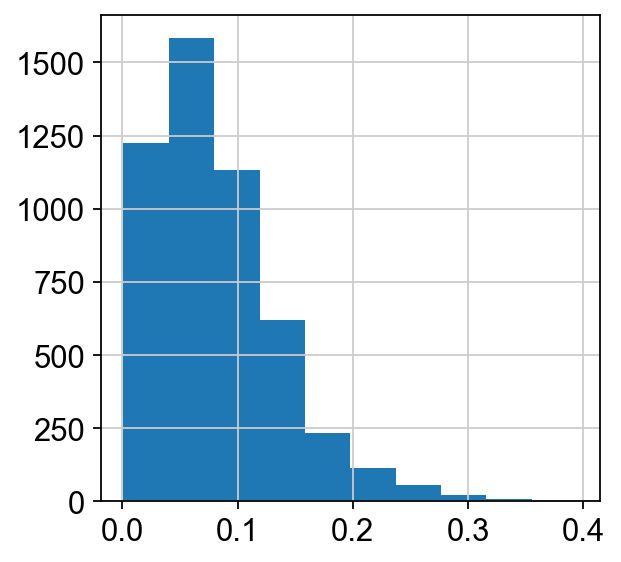

In [25]:
n_iters = 5000
fake_f_stat = get_perm_distr(df_cont, gene, both_index, ref_index.size, res_both, n_iters=n_iters)
permutation_p = np.count_nonzero(fake_f_stat >= f_stat) / n_iters
plt.hist(fake_f_stat);
permutation_p

In [26]:
from itertools import permutations, combinations

res_dict = dict()
conditions = ['human', 'chimp', 'macaque']
#permut = list(combinations(conditions, 2))
permut = list(combinations(conditions, 2))

for ref_specie, sec_specie in permut:
    res_list = []
    #not_const_genes = results[results[ref_specie] < 0.05].index
    for gene in tqdm(df.columns):
        # fit spline for ref specie
        # fit spline for reference specie
        ref_index = df_cont[df_cont.condition == ref_specie].index
        res_ref = fit_spline(df_cont, ref_index, gene)
        
        # fit spline for second specie
        sec_index = df_cont[df_cont.condition == sec_specie].index
        res_sec = fit_spline(df_cont, sec_index, gene)
        
        # fit spline for both species
        both_index = df_cont[df_cont.condition.isin([ref_specie, sec_specie])].index
        res_both = fit_spline(df_cont, both_index, gene)
        
        # calculate f_stat
        f_stat = (res_both - res_ref - res_sec) / (res_ref + res_sec)

        # find f-stat distr with permutations
        n_iters = 1000
        fake_f_stat = get_perm_distr(df_cont, gene, both_index, ref_index.size, res_both, n_iters=n_iters)
        permutation_p = np.count_nonzero(fake_f_stat >= f_stat) / n_iters
        
        # save results 
        res_list.append([f_stat, permutation_p])
    res_dict[f'{ref_specie}-{sec_specie}'] = pd.DataFrame(res_list, columns=['F-score', 'p-value'], index=df.columns)

  0%|          | 0/5390 [00:00<?, ?it/s]

  0%|          | 0/5390 [00:00<?, ?it/s]

  0%|          | 0/5390 [00:00<?, ?it/s]

In [27]:
res_dict.keys()

dict_keys(['human-chimp', 'human-macaque', 'chimp-macaque'])

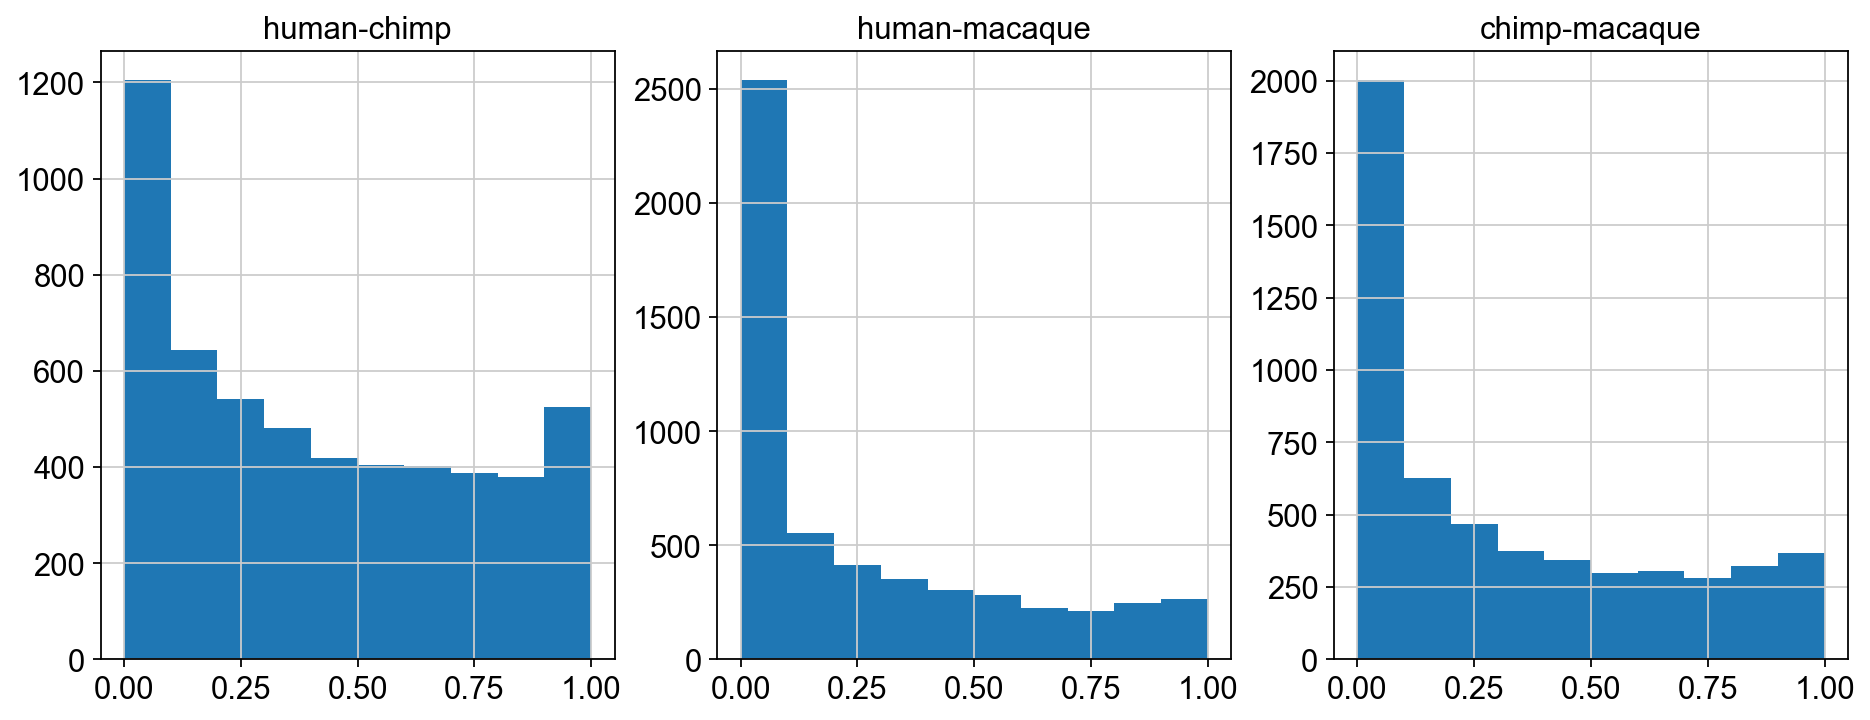

In [28]:
fig, axes = plt.subplots(1, 3,  figsize=(14, 5), gridspec_kw={'hspace': 0.4})

for (key, res_df), ax in zip(res_dict.items(), axes.flatten()):
    res_df['p-value'].hist(ax=ax)
    ax.set_title(key, fontsize=14)

In [29]:
import pickle

with open('results/ancova_perm_res.pkl', 'wb') as f:
    pickle.dump(res_dict, f)

# Visualise

In [11]:
pb_dir_path = '../../data/pseudobulks/'

In [12]:
adata_pb = sc.read_h5ad(pb_dir_path + 'pb_mammals_filtered.h5ad')
adata_pb

AnnData object with n_obs × n_vars = 89 × 9208
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition', 'lib_size', 'log_lib_size'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    layers: 'psbulk_props'

In [13]:
import pickle
with open("results/ancova_perm_res.pkl", "rb") as file:
    ancova_results = pickle.load(file)

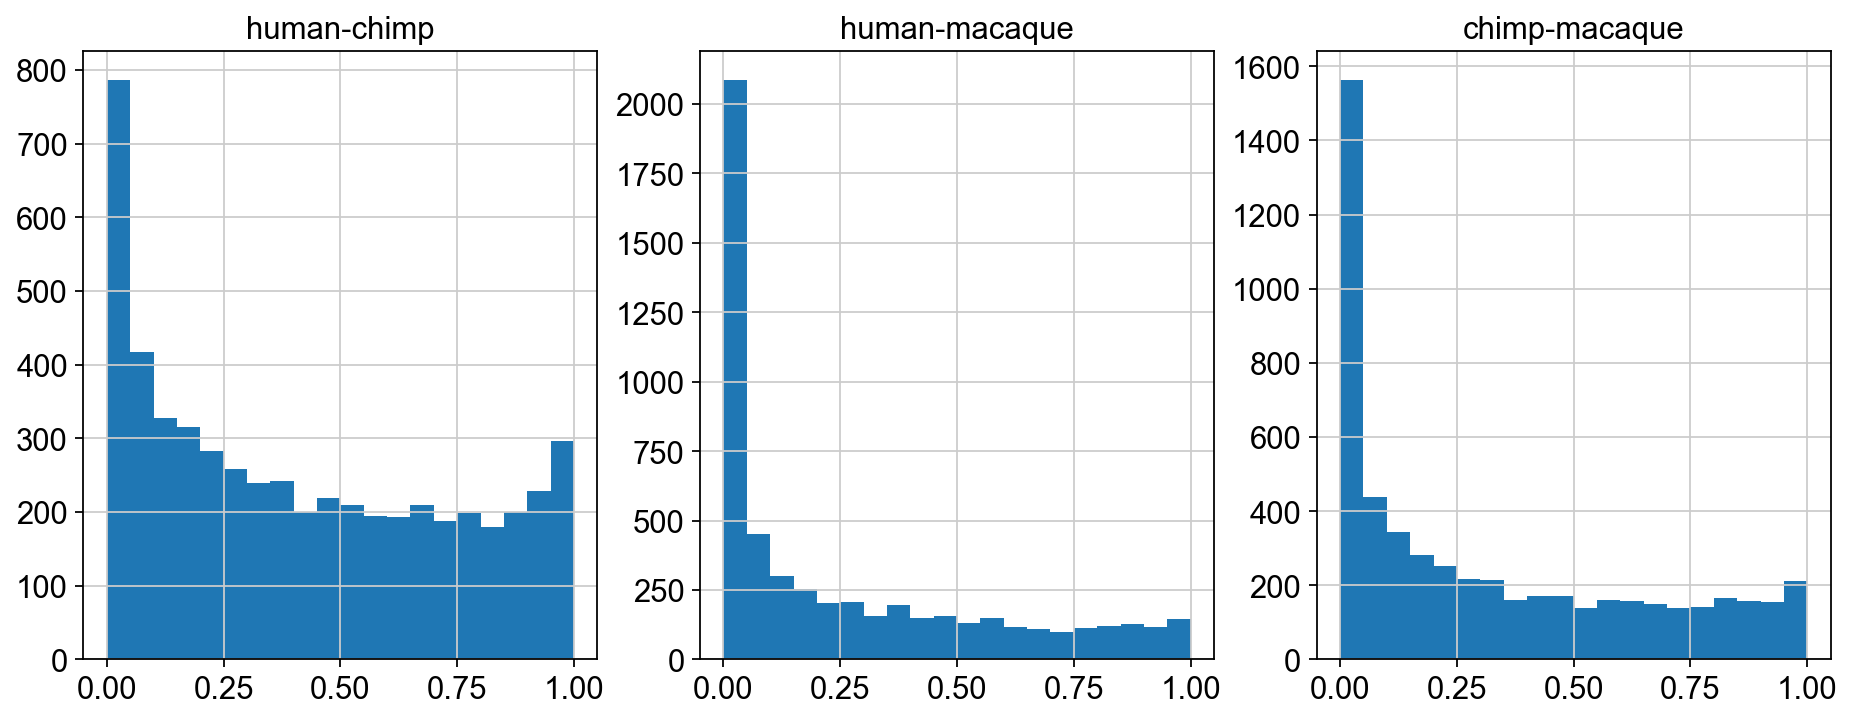

In [15]:
fig, axes = plt.subplots(1, 3,  figsize=(14, 5), gridspec_kw={'hspace': 0.4})

for (key, res_df), ax in zip(ancova_results.items(), axes.flatten()):
    res_df['p-value'].hist(ax=ax, bins=20)
    ax.set_title(key, fontsize=14)

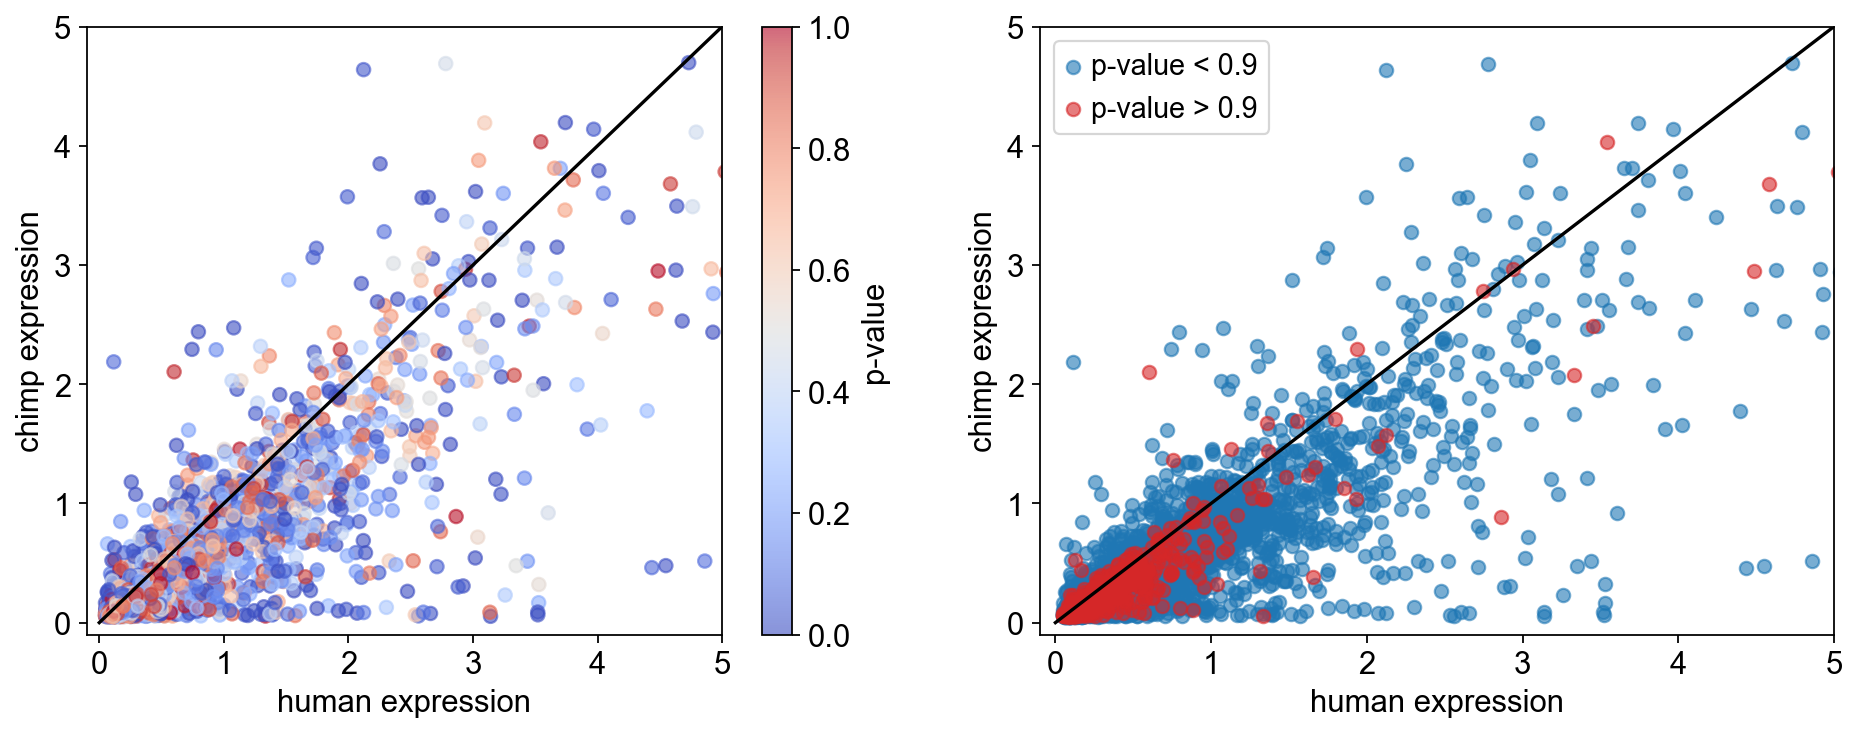

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

genes = background_genes
human_expr = adata_pb[adata_pb.obs.condition == 'human', genes].X.mean(axis=0)
chimp_expr = adata_pb[adata_pb.obs.condition == 'chimp', genes].X.mean(axis=0)

im = ax[0].scatter(human_expr, chimp_expr, c=ancova_results['human-chimp']['p-value'], cmap='coolwarm', marker='o', alpha=0.6)

ax[0].plot([0, 80], [0, 80], 'black')
ax[0].set_xlabel('human expression')
ax[0].set_ylabel('chimp expression')
ax[0].grid(False)
ax[0].set_xlim(-0.1, 5)
ax[0].set_ylim(-0.1, 5)
fig.colorbar(im, ax=ax[0], label="p-value")


res_df = ancova_results['human-chimp']
low_pv_genes = res_df[res_df['p-value'] > 0.9].index
genes = res_df.index.difference(low_pv_genes)
human_expr = adata_pb[adata_pb.obs.condition == 'human', genes].X.mean(axis=0)
chimp_expr = adata_pb[adata_pb.obs.condition == 'chimp', genes].X.mean(axis=0)

ax[1].scatter(human_expr, chimp_expr, c='tab:blue', marker='o', alpha=0.6, label='p-value < 0.9')

genes = low_pv_genes
human_expr = adata_pb[adata_pb.obs.condition == 'human', genes].X.mean(axis=0)
chimp_expr = adata_pb[adata_pb.obs.condition == 'chimp', genes].X.mean(axis=0)

ax[1].scatter(human_expr, chimp_expr, c='tab:red', marker='o', alpha=0.6, label='p-value > 0.9')

ax[1].plot([0, 80], [0, 80], 'black')
ax[1].set_xlabel('human expression')
ax[1].set_ylabel('chimp expression')
ax[1].grid(False)
ax[1].set_xlim(-0.1, 5)
ax[1].set_ylim(-0.1, 5)
ax[1].legend()

plt.show()

In [84]:
res_df = ancova_results['human-chimp']
low_pv_genes = res_df[res_df['p-value'] > 0.9].index

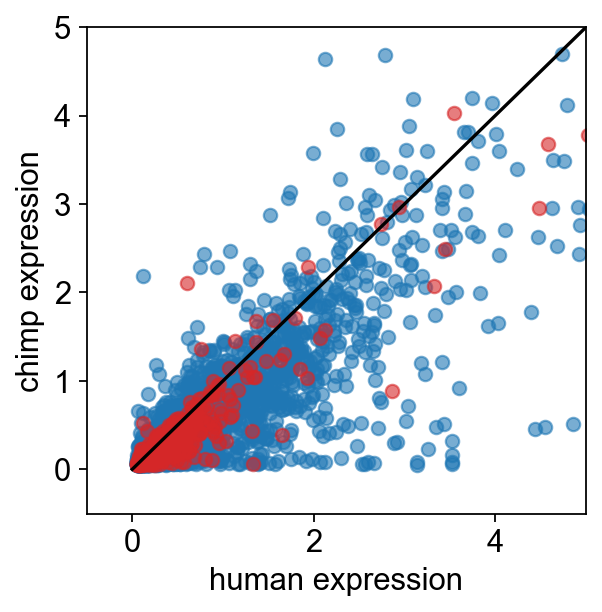

In [85]:
genes = res_df.index.difference(low_pv_genes)
human_expr = adata_pb[adata_pb.obs.condition == 'human', genes].X.mean(axis=0)
chimp_expr = adata_pb[adata_pb.obs.condition == 'chimp', genes].X.mean(axis=0)

plt.scatter(human_expr, chimp_expr, c='tab:blue', marker='o', alpha=0.6)

genes = low_pv_genes
human_expr = adata_pb[adata_pb.obs.condition == 'human', genes].X.mean(axis=0)
chimp_expr = adata_pb[adata_pb.obs.condition == 'chimp', genes].X.mean(axis=0)

plt.scatter(human_expr, chimp_expr, c='tab:red', marker='o', alpha=0.6)

plt.plot([0, 80], [0, 80], 'black')
plt.xlabel('human expression')
plt.ylabel('chimp expression')
plt.grid(False)
plt.xlim(-0.5, 5)
plt.ylim(-0.5, 5)
plt.show()

In [31]:
sign_genes = {key:value[value['p-value'] < 0.05].index for key, value in res_dict.items()}
sign_genes

{'human-chimp': Index(['ABCG4', 'ABHD6', 'ABI2', 'ABLIM3', 'ACHE', 'ACSL1', 'ACTG1', 'ACTN2',
        'ADAM15', 'ADGRB2',
        ...
        'ZEB2', 'ZFPL1', 'ZMYND8', 'ZNF32', 'ZNF362', 'ZNF608', 'ZNF689',
        'ZNF692', 'ZNF706', 'ZNF74'],
       dtype='object', length=786),
 'human-macaque': Index(['AACS', 'AAGAB', 'AAK1', 'AAR2', 'AARS1', 'AATK', 'ABAT', 'ABCC10',
        'ABCD4', 'ABHD10',
        ...
        'ZNF575', 'ZNF576', 'ZNF592', 'ZNF593', 'ZNF655', 'ZNF689', 'ZNF703',
        'ZNF706', 'ZNF768', 'ZNFX1'],
       dtype='object', length=2085),
 'chimp-macaque': Index(['AARS1', 'AATK', 'ABAT', 'ABCC10', 'ABCC8', 'ABCD4', 'ABHD10', 'ABLIM3',
        'ACAD9', 'ACADVL',
        ...
        'ZNF184', 'ZNF189', 'ZNF304', 'ZNF341', 'ZNF511', 'ZNF536', 'ZNF576',
        'ZNF655', 'ZNF689', 'ZNF703'],
       dtype='object', length=1562)}

In [32]:
hs_genes = sign_genes['human-chimp'].intersection(sign_genes['human-macaque']).difference(sign_genes['chimp-macaque'])
hs_genes, hs_genes.size

(Index(['ABHD6', 'ABI2', 'ADAM15', 'ADI1', 'ADORA1', 'AFTPH', 'AHNAK2', 'ALCAM',
        'AMFR', 'ANK2',
        ...
        'VIPAS39', 'VLDLR', 'WWP1', 'YWHAE', 'YWHAH', 'ZBTB18', 'ZBTB46',
        'ZEB2', 'ZNF362', 'ZNF706'],
       dtype='object', length=230),
 230)

In [33]:
cs_genes = sign_genes['chimp-macaque'].intersection(sign_genes['human-chimp']).difference(sign_genes['human-macaque'])
cs_genes, cs_genes.size

(Index(['ACHE', 'ACTN2', 'ANK3', 'ANKIB1', 'ARF5', 'ARID4A', 'ARID4B', 'AZIN2',
        'BAIAP2', 'BTF3', 'CAMK2G', 'COBL', 'CTDNEP1', 'DCAKD', 'DCBLD2',
        'DENND4B', 'DNAJB6', 'DYNC1I2', 'DYNC1LI1', 'ENOX1', 'FAM71E1',
        'FAM76A', 'FAU', 'GIPC1', 'GOLPH3', 'HCCS', 'HEY1', 'HINT1', 'HINT2',
        'HMGCLL1', 'HNRNPA3', 'HSPB11', 'KCNC2', 'KLF3', 'KXD1', 'LCMT1',
        'LRP3', 'LSM5', 'MAP3K7', 'METTL5', 'MGST3', 'MICU1', 'MIF', 'MORN4',
        'MRPL23', 'MRPL37', 'MRPS36', 'MYCBP2', 'NCOA3', 'NELL2', 'NETO1',
        'NUAK1', 'NUBP2', 'NUDCD1', 'NUP93', 'PARP8', 'PBRM1', 'PDE4B',
        'PITHD1', 'PLCB1', 'PML', 'POLR2C', 'PRXL2B', 'PTOV1', 'RADX',
        'RASL11B', 'RETREG1', 'RIPOR2', 'RNF2', 'RPL10', 'RPL35A', 'RPL5',
        'RPS16', 'RPS29', 'RPS5', 'RSL24D1', 'SCRN3', 'SDHD', 'SEC13', 'SEMA3A',
        'SERPINE2', 'SGTB', 'SLIRP', 'SORL1', 'SPP1', 'SRI', 'STARD4', 'STT3B',
        'SULF1', 'TAGLN2', 'TBC1D24', 'TMEM259', 'TSPAN3', 'UQCRH', 'USP11',
        'UTP1

In [34]:
ms_genes = sign_genes['chimp-macaque'].intersection(sign_genes['human-macaque']).difference(sign_genes['human-chimp'])
ms_genes, ms_genes.size

(Index(['AARS1', 'AATK', 'ABAT', 'ABCC10', 'ABCD4', 'ABHD10', 'ACAD9', 'ACADVL',
        'ACKR1', 'ACO1',
        ...
        'ZNF140', 'ZNF184', 'ZNF189', 'ZNF304', 'ZNF341', 'ZNF511', 'ZNF536',
        'ZNF576', 'ZNF655', 'ZNF703'],
       dtype='object', length=971),
 971)